# **Intent Based Sentiment (2 classes) IMDB Datasets (Pretrained + Base Model + Adapter)**

### Step 1: Install & Import Dependencies

In [1]:
!pip install -q transformers==4.41.2 peft==0.11.1 accelerate==0.31.0 datasets


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report, roc_auc_score, roc_curve, auc,
    brier_score_loss
)
from sklearn.calibration import calibration_curve
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

import torch
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    Trainer, TrainingArguments, EarlyStoppingCallback, AutoConfig
)
from peft import LoraConfig, TaskType, get_peft_model

### Step 2: Mount Google Drive & Load Data

In [4]:
file_path = "/home/arafatmdeasin/usman/project/dataset/IMDB Dataset (2 Classes).csv"
df = pd.read_csv(file_path, encoding='ISO-8859-1')
df = df[['Text', 'Sentiment']].dropna()
df.head()

,Text,Sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
total_instances = len(df)
print(f"Total instances: {total_instances}")

sentiment_counts = df['Sentiment'].value_counts()
print("Number of instances per sentiment:")
print(sentiment_counts)

Total instances: 50000
Number of instances per sentiment:
Sentiment
positive    25000
negative    25000
Name: count, dtype: int64


### Step 3: Visualize Dataset Distribution

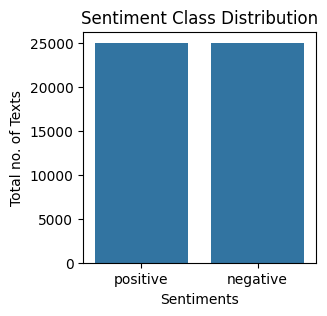

In [6]:
plt.figure(figsize=(3,3))
sns.countplot(data=df, x='Sentiment')
plt.title("Sentiment Class Distribution")
plt.xlabel("Sentiments")
plt.ylabel("Total no. of Texts")
plt.grid(False)
plt.show()


### Step 4: Encode Labels

In [7]:
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['Sentiment'])

print("Label Mapping:")
for i, label in enumerate(label_encoder.classes_):
    print(f"{label}: {i}")


Label Mapping:
negative: 0
positive: 1


### Step 5: Train-Test Split

In [8]:
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df['Text'].tolist(),
    df['label'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df['label']
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts,
    temp_labels,
    test_size=0.5,
    random_state=42,
    stratify=temp_labels
)

print(f"Train size: {len(train_texts)}, Val size: {len(val_texts)}, Test size: {len(test_texts)}")

Train size: 40000, Val size: 5000, Test size: 5000


### Step 6: Tokenization

In [9]:
base_model_name = "bert-base-uncased"
finetuned_model_name = "textattack/bert-base-uncased-imdb"
tokenizer = AutoTokenizer.from_pretrained(base_model_name)

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
val_encodings   = tokenizer(val_texts, truncation=True, padding=True, max_length=512)
test_encodings  = tokenizer(test_texts, truncation=True, padding=True, max_length=512)


### Step 7: Dataset Class

In [10]:
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()} | {'labels': torch.tensor(self.labels[idx])}

    def __len__(self):
        return len(self.labels)

train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset   = SentimentDataset(val_encodings, val_labels)
test_dataset  = SentimentDataset(test_encodings, test_labels)

### Step 8: Define Metrics Function

In [11]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    proba = torch.softmax(torch.tensor(logits), dim=-1).numpy()

    acc = accuracy_score(labels, preds) * 100

    prec, rec, f1, _ = precision_recall_fscore_support(labels, preds, average="macro")

    sims = []
    for i in range(len(labels)):
        true_onehot = np.zeros(proba.shape[1])
        true_onehot[labels[i]] = 1
        sims.append(cosine_similarity([true_onehot], [proba[i]])[0][0])
    similarity_score = np.mean(sims) * 100

    confidence_score = np.mean(np.max(proba, axis=1)) * 100

    return {
        "eval_Accuracy": acc,
        "eval_Precision": prec * 100,
        "eval_Recall": rec * 100,
        "eval_F1 Score": f1 * 100,
        "eval_Similarity Score": similarity_score,
        "eval_Confidence Score": confidence_score
    }


### Step 9: Evaluate Without Fine-Tuning

In [12]:
baseline_model = AutoModelForSequenceClassification.from_pretrained(finetuned_model_name)

baseline_trainer = Trainer(
    model=baseline_model,
    args=TrainingArguments(
        output_dir="./results",
        per_device_eval_batch_size=32
    ),
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

baseline_metrics = baseline_trainer.evaluate()

print("\n===== Performance of Pretrained Transformer Model =====\n")

metrics_to_show = [
    "Accuracy",
    "Precision",
    "Recall",
    "F1 Score",
    "Similarity Score",
    "Confidence Score"
]

for metric in metrics_to_show:
    key = f"eval_{metric}"
    if key in baseline_metrics:
        print(f"{metric} is: {baseline_metrics[key]:.2f}%")

print("\n===== Evaluation Details =====")
print(f"Eval Loss: {baseline_metrics.get('eval_loss', 0.0):.4f}")
print(f"Runtime: {baseline_metrics.get('eval_runtime', 0.0)} sec")
print(f"Samples per second: {baseline_metrics.get('eval_samples_per_second', 0.0)}")



===== Performance of Pretrained Transformer Model =====

Accuracy is: 95.62%
Precision is: 95.70%
Recall is: 95.62%
F1 Score is: 95.62%
Similarity Score is: 95.95%
Confidence Score is: 99.16%

===== Evaluation Details =====
Eval Loss: 0.2146
Runtime: 46.2607 sec
Samples per second: 108.083


### Step 9.1: Confusion Matrix (Without Fine-Tuning)

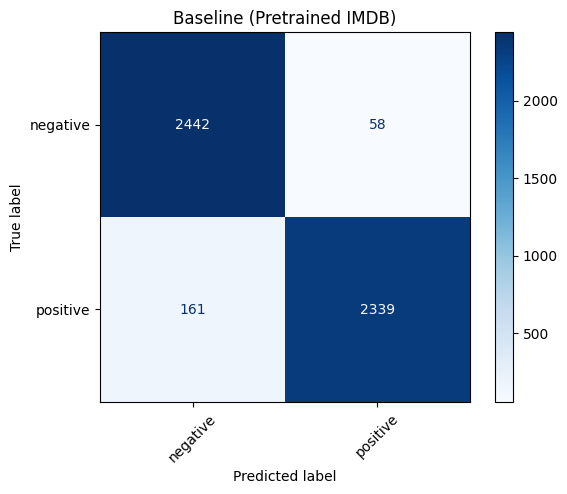

In [14]:
preds = baseline_trainer.predict(test_dataset)
y_true = preds.label_ids
y_pred = preds.predictions.argmax(-1)

cm = confusion_matrix(y_true, y_pred)

class_names = label_encoder.classes_

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names).plot(cmap="Blues", xticks_rotation=45)
plt.title("Baseline (Pretrained IMDB)")
plt.show()

### Step 10: Base Model Fine-Tuning Configuration & Training

In [15]:
config = AutoConfig.from_pretrained(
    base_model_name,
    num_labels=len(label_encoder.classes_),
    hidden_dropout_prob=0.3,
    attention_probs_dropout_prob=0.3,
    classifier_dropout=0.2
)

model_base = AutoModelForSequenceClassification.from_pretrained(
    base_model_name,
    config=config
)

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    weight_decay=0.1,
    warmup_ratio=0.1,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    logging_strategy="epoch",
    report_to="none",
    fp16=True,
    gradient_accumulation_steps=1,
    save_total_limit=2,
    max_grad_norm=1.0,
    lr_scheduler_type="linear",
    seed=42,
    dataloader_pin_memory=False,
)

trainer_base = Trainer(
    model=model_base,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[
        EarlyStoppingCallback(early_stopping_patience=3),
    ]
)

trainer_base.train()

/home/arafatmdeasin/usman/.ve_torch/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/arafatmdeasin/usman/.ve_torch/lib/python3.10/site-packages/accelerate/accelerator.py:477: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 score,Similarity score,Confidence score
1,0.374300,0.308796,92.240000,92.310432,92.240000,92.236769,92.797730,98.688583
2,0.273400,0.272435,93.160000,93.421474,93.160000,93.149687,93.605563,98.807945
3,0.219200,0.318914,93.460000,93.704529,93.460000,93.450839,93.707112,99.462578
4,0.174700,0.266884,94.380000,94.406438,94.380000,94.379163,94.553301,99.532997
5,0.135400,0.283758,94.540000,94.586805,94.540000,94.538567,94.658522,99.599800


TrainOutput(global_step=25000, training_loss=0.23538184814453125, metrics={'train_runtime': 2566.9132, 'train_samples_per_second': 77.915, 'train_steps_per_second': 9.739, 'total_flos': 5.2622211072e+16, 'train_loss': 0.23538184814453125, 'epoch': 5.0})

#### Step 10.1: Fine-Tuned Base Model Evaluation & Performance Analysis

In [16]:
finetuned_metrics = trainer_base.evaluate(test_dataset)

print("\n===== Performance after Fine-Tuning Base Model =====\n")

metrics_to_show = [
    "Accuracy",
    "Precision",
    "Recall",
    "F1 Score",
    "Similarity Score",
    "Confidence Score"
]

for metric in metrics_to_show:
    key = f"eval_{metric}"
    if key in finetuned_metrics:
        print(f"{metric} is: {finetuned_metrics[key]:.2f}%")

print("\n===== Evaluation Details =====")
print(f"Eval Loss: {finetuned_metrics.get('eval_loss', 0.0):.4f}")
print(f"Runtime: {finetuned_metrics.get('eval_runtime', 0.0)} sec")
print(f"Samples per second: {finetuned_metrics.get('eval_samples_per_second', 0.0)}")



===== Performance after Fine-Tuning Base Model =====

Accuracy is: 94.68%
Precision is: 94.69%
Recall is: 94.68%
F1 Score is: 94.68%
Similarity Score is: 94.83%
Confidence Score is: 99.53%

===== Evaluation Details =====
Eval Loss: 0.2629
Runtime: 14.753 sec
Samples per second: 338.915


#### Step 10.2: Confusion Matrix Analysis

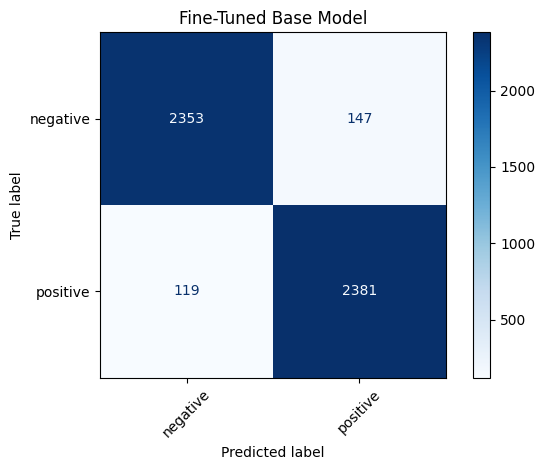

In [17]:
preds = trainer_base.predict(test_dataset)
y_true = preds.label_ids
y_pred = preds.predictions.argmax(-1)

cm = confusion_matrix(y_true, y_pred)

class_names = label_encoder.classes_

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names).plot(
    cmap="Blues",
    xticks_rotation=45
)
plt.title("Fine-Tuned Base Model")
plt.tight_layout()
plt.show()

#### Step 10.3: Training Progress Visualization & Loss Analysis

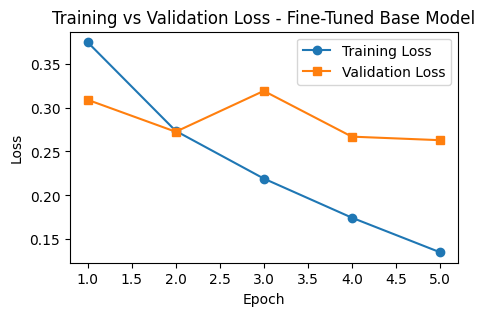

In [18]:
logs_base = trainer_base.state.log_history

train_loss_base = {}
eval_loss_base = {}

for log in logs_base:
    if "loss" in log and "epoch" in log:
        train_loss_base[float(log["epoch"])] = log["loss"]
    if "eval_loss" in log and "epoch" in log:
        eval_loss_base[float(log["epoch"])] = log["eval_loss"]

epochs_base = sorted(set(train_loss_base.keys()) | set(eval_loss_base.keys()))
train_vals_base = [train_loss_base.get(e, None) for e in epochs_base]
eval_vals_base = [eval_loss_base.get(e, None) for e in epochs_base]

# Plot
plt.figure(figsize=(5,3))
plt.plot(epochs_base, train_vals_base, label="Training Loss", marker="o")
plt.plot(epochs_base, eval_vals_base, label="Validation Loss", marker="s")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss - Fine-Tuned Base Model")
plt.legend()
plt.grid(False)
plt.show()


### Step 11: Adapter (LoRA) Model Configuration & Training

In [19]:
adapter_model = AutoModelForSequenceClassification.from_pretrained(
    base_model_name,
    num_labels=len(label_encoder.classes_)
)

peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=16,
    lora_alpha=32,
    lora_dropout=0.2,
    target_modules=["query", "key", "value", "dense"],  
    bias="none",
    modules_to_save=["classifier"]  
)

adapter_model = get_peft_model(adapter_model, peft_config)
adapter_model.print_trainable_parameters()

adapter_args = TrainingArguments(
    output_dir="./results-bert-lora",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1.5e-4,  
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    weight_decay=0.05,
    warmup_ratio=0.1,
    logging_dir="./logs-bert-lora",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none",
    seed=42,
    fp16=True,
    gradient_accumulation_steps=1,
    max_grad_norm=1.0,
    logging_steps=50,
    save_total_limit=2,
    lr_scheduler_type="cosine",
    dataloader_pin_memory=False,
    remove_unused_columns=True
)

trainer_adapter = Trainer(
    model=adapter_model,
    args=adapter_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[
        EarlyStoppingCallback(early_stopping_patience=3),
    ]
)

print("Training BERT-base-uncased with LoRA on IMDB dataset...")
trainer_adapter.train()

# Evaluation
adapter_metrics = trainer_adapter.evaluate(test_dataset)
print("Performance with BERT + LoRA (Adapter):", adapter_metrics)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/arafatmdeasin/usman/.ve_torch/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/home/arafatmdeasin/usman/.ve_torch/lib/python3.10/site-packages/accelerate/accelerator.py:477: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


trainable params: 2,680,322 || all params: 112,164,100 || trainable%: 2.3896
Training BERT-base-uncased with LoRA on IMDB dataset...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 score,Similarity score,Confidence score
1,0.286700,0.188915,92.840000,92.873613,92.840000,92.838596,94.071895,96.195610
2,0.169500,0.178968,93.280000,93.462501,93.280000,93.272938,94.457852,95.909958
3,0.121100,0.192504,94.400000,94.486125,94.400000,94.397288,95.007917,98.165642
4,0.083600,0.202460,94.600000,94.615105,94.600000,94.599543,95.045776,98.597504
5,0.062700,0.219655,94.580000,94.612042,94.580000,94.579027,94.968960,98.846939


/home/arafatmdeasin/usman/.ve_torch/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/arafatmdeasin/usman/.ve_torch/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/arafatmdeasin/usman/.ve_torch/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/arafatmdeasin/usman/.ve_torch/lib/python3.10/site-packages/huggingface

Performance with BERT + LoRA (Adapter): {'eval_Accuracy': 92.72, 'eval_Precision': 93.0235743405469, 'eval_Recall': 92.72, 'eval_F1 Score': 92.70713538682236, 'eval_Similarity Score': 93.95430956678426, 'eval_Confidence Score': 96.05308532714844, 'eval_loss': 0.2012687623500824, 'eval_runtime': 20.8501, 'eval_samples_per_second': 239.807, 'eval_steps_per_second': 7.53, 'epoch': 5.0}


#### Step 11.1: Adapter (LoRA) Model Evaluation & Performance Analysis

In [20]:
adapter_metrics = trainer_adapter.evaluate(test_dataset)

print("\n===== Performance with Adapter (LoRA) =====\n")

metrics_to_show = [
    "Accuracy",
    "Precision",
    "Recall",
    "F1 Score",
    "Similarity Score",
    "Confidence Score"
]

for metric in metrics_to_show:
    key = f"eval_{metric}"
    if key in adapter_metrics:
        print(f"{metric} is: {adapter_metrics[key]:.2f}%")

print("\n===== Evaluation Details =====")
print(f"Eval Loss: {adapter_metrics.get('eval_loss', 0.0):.4f}")
print(f"Runtime: {adapter_metrics.get('eval_runtime', 0.0)} sec")
print(f"Samples per second: {adapter_metrics.get('eval_samples_per_second', 0.0)}")



===== Performance with Adapter (LoRA) =====

Accuracy is: 92.72%
Precision is: 93.02%
Recall is: 92.72%
F1 Score is: 92.71%
Similarity Score is: 93.95%
Confidence Score is: 96.05%

===== Evaluation Details =====
Eval Loss: 0.2013
Runtime: 21.0536 sec
Samples per second: 237.489


#### Step 11.2: Confusion Matrix Analysis

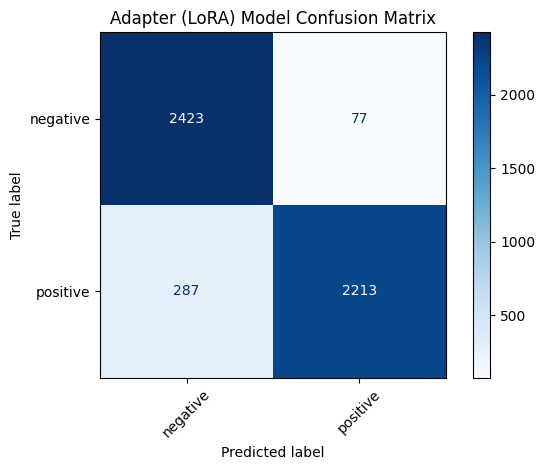

In [21]:
preds = trainer_adapter.predict(test_dataset)
y_true, y_pred = preds.label_ids, preds.predictions.argmax(-1)
cm = confusion_matrix(y_true, y_pred)
class_names = label_encoder.classes_
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names).plot(cmap="Blues", xticks_rotation=45)
plt.title("Adapter (LoRA) Model Confusion Matrix")
plt.tight_layout()
plt.show()

#### Step 11.3: Training Progress Visualization & Loss Analysis

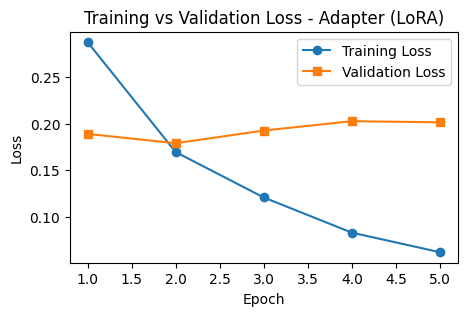

In [22]:
 logs_adapter = trainer_adapter.state.log_history

train_loss_adapter = {}
eval_loss_adapter = {}

for log in logs_adapter:
    if "loss" in log and "epoch" in log:
        train_loss_adapter[float(log["epoch"])] = log["loss"]
    if "eval_loss" in log and "epoch" in log:
        eval_loss_adapter[float(log["epoch"])] = log["eval_loss"]

epochs_adapter = sorted(set(train_loss_adapter.keys()) | set(eval_loss_adapter.keys()))
train_vals_adapter = [train_loss_adapter.get(e, None) for e in epochs_adapter]
eval_vals_adapter = [eval_loss_adapter.get(e, None) for e in epochs_adapter]

# Plot
plt.figure(figsize=(5,3))
plt.plot(epochs_adapter, train_vals_adapter, label="Training Loss", marker="o")
plt.plot(epochs_adapter, eval_vals_adapter, label="Validation Loss", marker="s")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss - Adapter (LoRA)")
plt.legend()
plt.grid(False)
plt.show()


### Step 12: Comprehensive Model Comparison & Performance Visualization

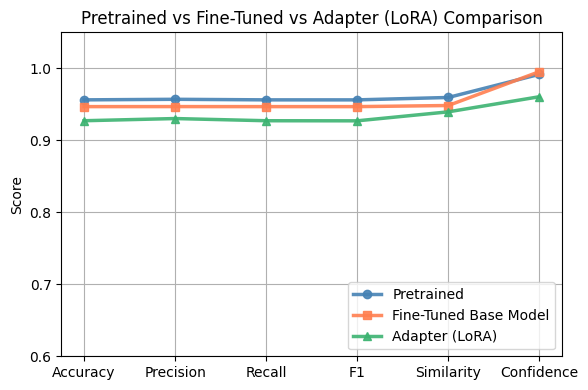

In [27]:
metrics = ["Accuracy", "Precision", "Recall", "F1", "Similarity", "Confidence"]

pretrained_vals = np.array([baseline_metrics[f"eval_{m}"] for m in ["Accuracy", "Precision", "Recall", "F1 Score", "Similarity Score", "Confidence Score"]]) / 100
base_vals = np.array([finetuned_metrics[f"eval_{m}"] for m in ["Accuracy", "Precision", "Recall", "F1 Score", "Similarity Score", "Confidence Score"]]) / 100
adapter_vals = np.array([adapter_metrics[f"eval_{m}"] for m in ["Accuracy", "Precision", "Recall", "F1 Score", "Similarity Score", "Confidence Score"]]) / 100

x = np.arange(len(metrics))

plt.figure(figsize=(6, 4))

plt.plot(x, pretrained_vals, marker='o', linestyle='-', linewidth=2.5, alpha=0.9, label="Pretrained", color='steelblue')
plt.plot(x, base_vals, marker='s', linestyle='-', linewidth=2.5, alpha=0.9, label="Fine-Tuned Base Model", color='coral')
plt.plot(x, adapter_vals, marker='^', linestyle='-', linewidth=2.5, alpha=0.9, label="Adapter (LoRA)", color='mediumseagreen')

plt.xticks(x, metrics, fontsize=10)
plt.ylabel("Score")
plt.ylim(0.60, 1.05)
plt.title("Pretrained vs Fine-Tuned vs Adapter (LoRA) Comparison")
plt.grid(True)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()